In [ ]:
import pandas as pd
from sklearn.utils import shuffle

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout, Concatenate, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

# !pip install mtranslate
# from mtranslate import translate

pd.set_option('display.max_colwidth', None)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
all_filenames = ["/content/drive/MyDrive/GP_Chatbot_Dataset/neg.csv" , "/content/drive/MyDrive/GP_Chatbot_Dataset/pos.csv"]
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ]) [['sentence','type']]
combined_csv = combined_csv.dropna()
train = combined_csv
print(len(combined_csv ))

from sklearn.utils import shuffle
data = shuffle(combined_csv)
# train_df = train_df[:10000]

# all_filenames = pd.read_csv("/content/drive/MyDrive/GP_Chatbot_Dataset/neg.csv")
data.head()

167931


,sentence,type
77936,I try to do my best to follow the rules of the road both when I'm on my bike and in a car.,neg
50051,Very cool_comma_ I hope more people continue to recognize his talent and he gets the acclaim he deserves.,pos
44438,Then I looked back and thought about the starving kids in Antarctica.,neg
80991,I would definitely make digital copies and upload to a cloud or a disk in case something happens.,pos
10375,We were there for a week.,neg


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['sentence'], data['type'], test_size=0.1, random_state=37)

In [ ]:
import numpy as np
from sklearn import preprocessing

lb = preprocessing.LabelBinarizer()
lb.fit(data['type'])
train_labels = lb.transform(y_train)
test_labels = lb.transform(y_test)



print(train_labels)
train_data = data['sentence']
print(train_data.shape)
print(train_labels.shape)

[[1]
 [0]
 [0]
 ...
 [0]
 [0]
 [1]]
(167931,)
(151137, 1)


# USE Model

In [ ]:
%%time
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/5'
embed = hub.KerasLayer(module_url, trainable=True, name='USE_embedding')

CPU times: user 17.2 s, sys: 2.94 s, total: 20.1 s
Wall time: 24.9 s


In [ ]:
def get_model(module_url):
    model = tf.keras.Sequential([
    
        hub.KerasLayer(module_url, input_shape=[],dtype=tf.string, trainable=False),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['accuracy'])
    print(model.summary())
    return(model)
model = get_model(module_url)    

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 512)               147354880 
_________________________________________________________________
dense_6 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 147,389,825
Trainable params: 34,945
Non-trainable params: 147,354,880
_________________________________________________________________
None


In [ ]:
# checkpoint = ModelCheckpoint('/content/drive/MyDrive/GP_Chatbot_Dataset/models/USE_binary_model.h5', monitor='val_accuracy', save_best_only=True)

train_history = model.fit(
    X_train, train_labels,
    validation_split=0.30,
    epochs=10,
    # callbacks=[checkpoint],
    batch_size = 512
)

Epoch 1/3
207/207 [==============================] - 1219s 6s/step - loss: 0.5688 - accuracy: 0.7167 - val_loss: 0.5158 - val_accuracy: 0.7458
Epoch 2/3
207/207 [==============================] - 1210s 6s/step - loss: 0.4989 - accuracy: 0.7564 - val_loss: 0.5094 - val_accuracy: 0.7479
Epoch 3/3
207/207 [==============================] - 1211s 6s/step - loss: 0.4750 - accuracy: 0.7727 - val_loss: 0.5161 - val_accuracy: 0.7441


Minimum validation loss reached in epoch 10


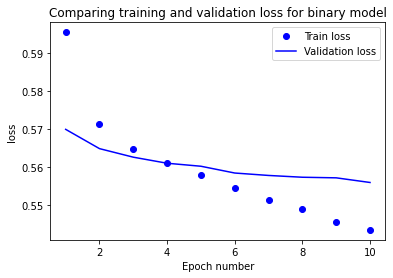

In [ ]:
import collections
import matplotlib.pyplot as plt

NB_START_EPOCHS = 10
min = optimal_epoch(train_history)
eval_metric(model, train_history, 'loss', 'for binary model')


In [ ]:
BATCH_SIZE = 512
results = test_model(model, X_train, train_labels, X_test, test_labels, min)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/GP_Chatbot_Dataset/models/USE_binary_model.h5' , custom_objects={'KerasLayer': hub.KerasLayer})

In [ ]:
import operator
input_msg = "I am happy that you are ok. i wish you are always happy and In good health. i love everything about you you are the best."
# input_msg = translate(input_msg ,'en')
print(input_msg)
test_pred = model.predict([str(input_msg)])
print(test_pred)

if test_pred > 0.5:
    print('positive')
else:
        print('negative')

I am happy that you are ok. i wish you are always happy and In good health. i love everything about you you are the best.
[[0.55122054]]
positive
